# Preparação dos dados

A principal e parte mais trabalhosa desse projeto com certeza é a preparação de dados, anteriormente até ao feature engineering.

Sendo essa parte  diretamente para a construção e desenvolvimento do feature engineering para a criação da base de dados para finalmente ser possível a aplicação dos métodos de ML. 

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df =  pd.read_csv("data/results.csv")

In [3]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [4]:
df.dtypes

date           object
home_team      object
away_team      object
home_score    float64
away_score    float64
tournament     object
city           object
country        object
neutral          bool
dtype: object

In [5]:
df["date"] = pd.to_datetime(df["date"])

In [6]:
df.isna().sum()

date           0
home_team      0
away_team      0
home_score    48
away_score    48
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [7]:
df = df.dropna()

Vamos utilizar um corte nos histórico de jogos para simplificar o feature engineering, pois partidas muito antigas não influenciam em nada nas partidas atuais.

Por isso o dataset com as partidas das seleções será cortado em 14/06/2018 (data da primeira partida na Copa do Mundo de 2018), assim selecionando todo o ciclo da Copa do Mundo e a Copa do Mundo de 2018 até as últimas partidas antes da Copa do Mundo de 2022.

Assim a ideia central é analisar os jogos de preparação e classificação para a Copa do Mundo.

In [8]:
df[(df["date"] >= "2018-6-14")].reset_index(drop=True)['date'].min()

Timestamp('2018-06-14 00:00:00')

In [9]:
df = df.query("date >= '2018-6-14'").reset_index(drop=True)

In [10]:
df.home_team.value_counts()

United States    45
Mexico           43
Qatar            40
South Korea      39
Brazil           39
                 ..
Bhutan            1
Tonga             1
Alderney          1
Saint Helena      1
Chameria          1
Name: home_team, Length: 247, dtype: int64

In [11]:
rank = pd.read_csv("data/fifa_ranking-2022-10-06.csv")

In [12]:
rank.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


In [13]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank.query("rank_date >= '2018-6-14'").reset_index(drop=True)

In [14]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

A ideia do agrupamento é fazer com que o merge entre os jogos das seleções com o ranking da FIFA seja possível.

O método **ffill** propaga a última informação até a próxima informação válida

In [15]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [16]:
rank.head()

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,2018-07-01,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
1,2018-07-02,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
2,2018-07-03,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
3,2018-07-04,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
4,2018-07-05,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC


### Criação de um escore baseado na classificação e pontuação dos times no ranking da FIFA

Categorizando os times no ranking da FIFA de acordo com sua pontuação, assim a pontuação se torna menos importante, mas sim um scores para o nível global da seleção. 

Os níveis e scores serão:

* Classe S => 1 => Até 100 pontos de diferença do primeiro lugar
* Classe S- => 2 => Até 200 pontos de diferença do primeiro lugar
* Classe A => 4 => Até 400 pontos de diferença do primeiro lugar
* Classe B => 6 => Até 600 pontos de diferença do primeiro lugar
* Classe C => 8 => Até 800 pontos de diferença do primeiro lugar
* Classe D => 10 => Mais de 800 pontos de diferença do primeiro lugar 

In [17]:
dates = rank['rank_date'].unique()

In [18]:
len(rank)

329074

In [19]:
rank['country_classification'] = None
for date in dates:
    max_points = rank.loc[rank['rank_date'] == date, :]['total_points'].max()
    conditions = [
                (rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 800)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 800) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 600)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 600) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 400)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 400) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 200)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 200) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 100)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 100)),
            ]

    choices = [10, 8, 6, 4, 2, 1]

    rank.loc[rank['rank_date'] == date, ['country_classification']] = np.select(conditions, choices)

In [20]:
rank.loc[rank['country_full'] == 'Russia', :]

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,country_classification
243258,2018-07-01,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243259,2018-07-02,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243260,2018-07-03,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243261,2018-07-04,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243262,2018-07-05,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
...,...,...,...,...,...,...,...,...,...
244812,2022-10-02,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4
244813,2022-10-03,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4
244814,2022-10-04,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4
244815,2022-10-05,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4


In [21]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date", "country_classification"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date", "country_classification"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [22]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,country_classification_home,total_points_away,previous_points_away,rank_away,rank_change_away,country_classification_away
2557,2021-11-11,Brazil,Colombia,1.0,0.0,FIFA World Cup qualification,São Paulo,Brazil,False,1820.36,1811.73,2.0,0.0,1,1618.76,1618.40,16.0,0.0,4
2658,2021-11-16,Argentina,Brazil,0.0,0.0,FIFA World Cup qualification,San Juan,Argentina,False,1738.79,1725.31,6.0,0.0,1,1820.36,1811.73,2.0,0.0,1
2766,2022-01-27,Ecuador,Brazil,1.0,1.0,FIFA World Cup qualification,Quito,Ecuador,False,1448.27,1448.74,46.0,0.0,4,1826.35,1826.35,2.0,0.0,1
2799,2022-02-01,Brazil,Paraguay,4.0,0.0,FIFA World Cup qualification,Belo Horizonte,Brazil,False,1826.35,1826.35,2.0,0.0,1,1454.52,1454.52,43.0,0.0,4
2840,2022-03-24,Brazil,Chile,4.0,0.0,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,1823.42,1826.35,2.0,0.0,1,1543.16,1543.42,26.0,2.0,4
2923,2022-03-29,Bolivia,Brazil,0.0,4.0,FIFA World Cup qualification,La Paz,Bolivia,False,1308.12,1324.21,76.0,-1.0,6,1823.42,1826.35,2.0,0.0,1
3015,2022-06-02,South Korea,Brazil,1.0,5.0,Friendly,Seoul,South Korea,False,1519.54,1522.85,29.0,0.0,4,1832.69,1823.42,1.0,-1.0,1
3083,2022-06-06,Japan,Brazil,0.0,1.0,Friendly,Tokyo,Japan,False,1553.44,1549.82,23.0,0.0,4,1832.69,1823.42,1.0,-1.0,1
3260,2022-09-23,Brazil,Ghana,3.0,0.0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1,1393.47,1389.68,60.0,0.0,6
3329,2022-09-27,Brazil,Tunisia,5.0,1.0,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1,1507.86,1507.86,30.0,0.0,4


Agora, nós temos os dados para criar as variáveis independentes baseadas nos resultados dos jogos e ranking da FIFA, sendo as principais variáveis: o número de gols das equipes, sua colocação no ranking da FIFA e o tipo do jogo.

# Feature Engineering

Com a definição central do DataFrame vamos criar algumas variáveis que tem impacto na predição dos jogos:

- Pontos feitos em jogos anteriores
- Gols marcados e sofridos em partidas anterioees
- Importância da partida (amistoso ou não)
- Posição dos times no ranking da FIFA
- Evolução do ranking das seleções
- Gols sofridos e marcados pelo ranking da equipe

Começaremos definindo os vencedores e perdedores, assim como seus pontos, em cada partida.

In [23]:
df = df_wc_ranked

In [24]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [25]:
df[["result", "home_team_points", "away_team_points"]] = results

O padrão do futebol atual é utilizar 3 pontos para vitória, 1 ponto para empate e 0 para derrota.
O ranking da FIFA é construído com essa base, no entanto a  FIFA utiliza pontuações específicas para cada nível de partida e o adversário enfrentado.
Assim a pontuação da seleção no ranking com sua posição deve ser negativamente correlacionado.

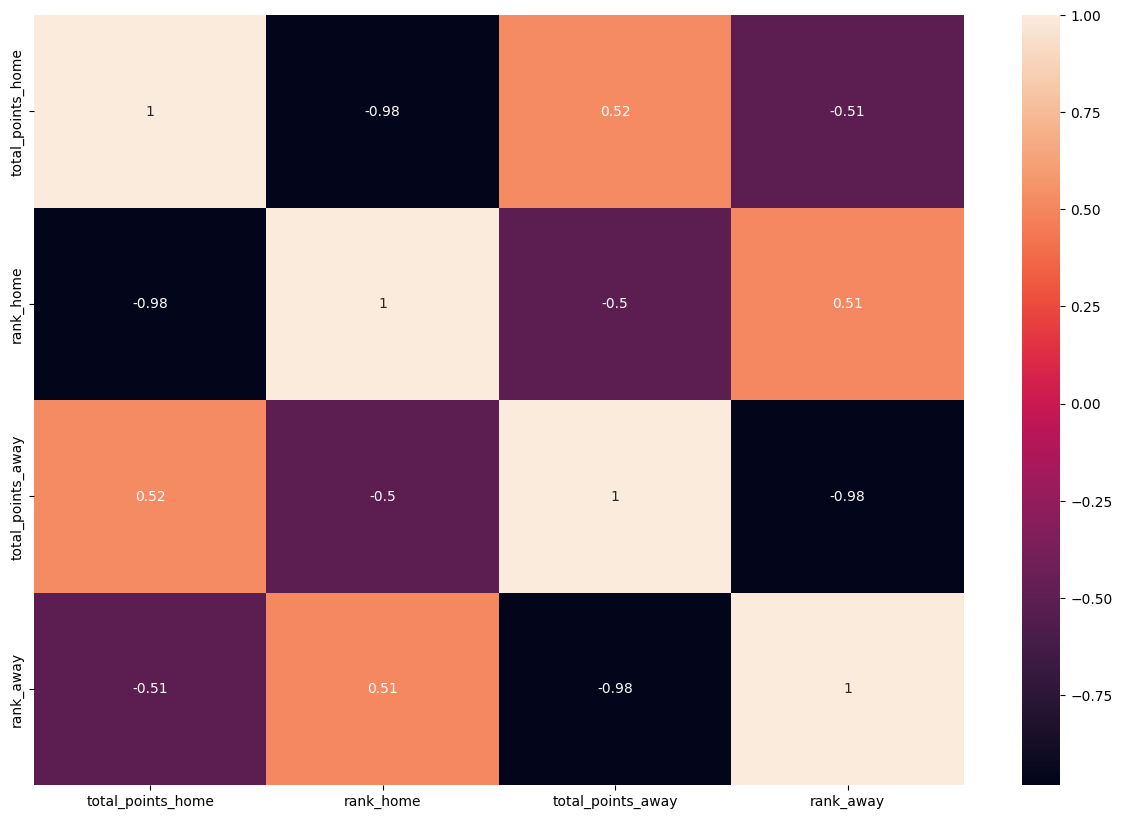

In [26]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr(), annot=True)
plt.show()

Começaremos criando variáveis que iram ajudar a criar outras variáveis: Diferença de Ranking, Diferença de Gols, pontos ganho no jogo pelo ranking do time (quanto maior o ranking, mais vale os pontos). Precisaremos criar as mesmas variáveis para os times da casa, quanto para o time de fora.

In [27]:
df[['home_team', 'away_team', 'home_score', 'away_score', 'total_points_home', 'rank_home', 'rank_away', 'result', 'home_team_points', 'away_team_points', "country_classification_home", "country_classification_away"]].head(10)

,home_team,away_team,home_score,away_score,total_points_home,rank_home,rank_away,result,home_team_points,away_team_points,country_classification_home,country_classification_away
0,Russia,Spain,1.0,1.0,1758.0,49.0,6.0,2,1,1,6,1
1,Croatia,Denmark,1.0,1.0,2036.0,12.0,15.0,2,1,1,2,2
2,Brazil,Mexico,2.0,0.0,2160.0,4.0,10.0,0,3,0,1,2
3,Belgium,Japan,3.0,2.0,2124.0,5.0,41.0,0,3,0,1,4
4,Sweden,Switzerland,1.0,0.0,1955.0,21.0,8.0,0,3,0,4,1
5,Colombia,England,1.0,1.0,1998.0,17.0,7.0,2,1,1,2,1
6,Malaysia,Fiji,1.0,0.0,1004.0,171.0,167.0,0,3,0,10,10
7,Uruguay,France,0.0,2.0,2017.0,14.0,2.0,1,0,3,2,1
8,Brazil,Belgium,1.0,2.0,2160.0,4.0,5.0,1,0,3,1,1
9,Sweden,England,0.0,2.0,1955.0,21.0,7.0,1,0,3,4,1


In [28]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]
df["points_home_by_classification"] = df["home_team_points"]/df["country_classification_away"]
df["points_away_by_classification"] = df["away_team_points"]/df["country_classification_home"]


In [29]:
df[['home_team', 'away_team', 'result','rank_home', 'rank_away', 'home_team_points', 'away_team_points', 'sg', 'rank_dif', 'points_home_by_rank', 'points_away_by_rank', 'points_home_by_classification', 'points_away_by_classification']].head(10)

,home_team,away_team,result,rank_home,rank_away,home_team_points,away_team_points,sg,rank_dif,points_home_by_rank,points_away_by_rank,points_home_by_classification,points_away_by_classification
0,Russia,Spain,2,49.0,6.0,1,1,0.0,43.0,0.166667,0.020408,1.0,0.166667
1,Croatia,Denmark,2,12.0,15.0,1,1,0.0,-3.0,0.066667,0.083333,0.5,0.5
2,Brazil,Mexico,0,4.0,10.0,3,0,2.0,-6.0,0.300000,0.000000,1.5,0.0
3,Belgium,Japan,0,5.0,41.0,3,0,1.0,-36.0,0.073171,0.000000,0.75,0.0
4,Sweden,Switzerland,0,21.0,8.0,3,0,1.0,13.0,0.375000,0.000000,3.0,0.0
5,Colombia,England,2,17.0,7.0,1,1,0.0,10.0,0.142857,0.058824,1.0,0.5
6,Malaysia,Fiji,0,171.0,167.0,3,0,1.0,4.0,0.017964,0.000000,0.3,0.0
7,Uruguay,France,1,14.0,2.0,0,3,-2.0,12.0,0.000000,0.214286,0.0,1.5
8,Brazil,Belgium,1,4.0,5.0,0,3,-1.0,-1.0,0.000000,0.750000,0.0,3.0
9,Sweden,England,1,21.0,7.0,0,3,-2.0,14.0,0.000000,0.142857,0.0,0.75


Para melhorar a criação das features, vamos separar o dataset em dois: time de casa e timede fora, para podermos mensurar o valor dos jogos. Depois disso vamos juntá-los novamente, obtendo o dataset original. Somente para otimizar o processo de criação das features/variáveis.

In [30]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points", "country_classification_home", "points_home_by_classification"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points", "country_classification_away", "points_away_by_classification"]]

In [31]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [32]:
home_team.head()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.0,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.0,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.0,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.0,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.0,0,13.0,0.375000,3,4,3.0


In [33]:
team_stats = home_team.append(away_team)#.sort_values("date")

C:\Users\user\AppData\Local\Temp\ipykernel_16596\275322566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)#.sort_values("date")


In [34]:
team_stats.head()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.0,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.0,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.0,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.0,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.0,0,13.0,0.375000,3,4,3.0


In [35]:
print(f'Para o feature engineering ficar mais simples, tinhamos um dataframe das partidas com {home_team.shape[0]} linhas e agora temos um dataframe com {team_stats.shape[0]}, sendo cada seleção uma linha, sem ser as partidas.')

Para o feature engineering ficar mais simples, tinhamos um dataframe das partidas com 3365 linhas e agora temos um dataframe com 6730, sendo cada seleção uma linha, sem ser as partidas.


In [36]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Agora, podemos criar algumas variáveis independentes, como:

- Média de gols da seleção no Ciclo da Copa do Mundo.
- Média de gols no time nos últimos 5 jogos.
- Média de gols sofridos do time nos últimos 5 jogos.
- Média de gols sofridos do time no Ciclo da Copa do Mundo.
- Média do Ranking da Fifa dos times enfrentados no Ciclo da Copa do Mundo.
- Média do Ranking da Fifa dos times adversários nos últimos 5 jogos.
- Pontuação FIFA conquistada no Ranking 
- Pontuação FIFA conquistada no Ranking nos últimos jogos.
- Média de pontuação conquistada no ciclo da copa
- Média de pontuação conquistada nos últimos 5 jogos
- Média de pontos conquistados pelo ranking do time adversário no ciclo da copa
- Média de pontos conquistados pelo ranking do time adversário nos últimos 5 jogos
- Média de pontos conquistados pela classificação do time adversário no ciclo da copa
- Média de pontos conquistados pela classificação do time adversário nos últimos 5 jogos

In [37]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
3361,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
3362,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.0
3363,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.0


In [38]:
team_stats.shape[0]/2

3365.0

In [39]:
team_stats.iloc[int(team_stats.shape[0]/2)]

date                        2018-07-01 00:00:00
team                                      Spain
score                                       1.0
suf_score                                   1.0
rank                                        6.0
rank_suf                                   49.0
rank_change                                -2.0
total_points                             2104.0
result                                        2
rank_dif                                   43.0
points_by_rank                         0.020408
team_points                                   1
country_classification                        1
points_by_classification               0.166667
Name: 0, dtype: object

In [40]:
team_stats.head()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.0,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.0,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.0,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.0,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.0,0,13.0,0.375000,3,4,3.0


In [41]:
# for index, row in team_stats.iterrows():
#     print(row)

In [42]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.query("team == @team & date < @date").sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    last10 = past_games.head(10)
    last15 = past_games.head(15)
    last30 = past_games.head(30)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    goals_l10 = last10["score"].mean()
    goals_l15 = last15["score"].mean()
    goals_l30 = last30["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    goals_suf_l10 = last10["suf_score"].mean()
    goals_suf_l15 = last15["suf_score"].mean()
    goals_suf_l30 = last30["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    rank_l10 = last10["rank_suf"].mean()
    rank_l15 = last15["rank_suf"].mean()
    rank_l30 = last30["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
        points_l10 = last10["total_points"].values[0] - last10["total_points"].values[-1]
        points_l15 = last15["total_points"].values[0] - last15["total_points"].values[-1]
        points_l30 = last30["total_points"].values[0] - last30["total_points"].values[-1]
    else:
        points = 0
        points_l5 = 0
        points_l10 = 0
        points_l15 = 0
        points_l30 = 0
    
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    gp_l10 = last10["team_points"].mean()
    gp_l15 = last15["team_points"].mean()
    gp_l30 = last30["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    gp_rank_l10 = last10["points_by_rank"].mean()
    gp_rank_l15 = last15["points_by_rank"].mean()
    gp_rank_l30 = last30["points_by_rank"].mean()

    cp_rank = past_games["points_by_classification"].mean()
    cp_rank_l5 = last5["points_by_classification"].mean()
    cp_rank_l10 = last10["points_by_classification"].mean()
    cp_rank_l15 = last15["points_by_classification"].mean()
    cp_rank_l30 = last30["points_by_classification"].mean()
    
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5, cp_rank, cp_rank_l5,
                    goals_l10, goals_l15, goals_l30, goals_suf_l10, goals_suf_l15, goals_suf_l30, rank_l10, rank_l15, rank_l30, points_l10, points_l15, points_l30, 
                    gp_l10, gp_l15, gp_l30, gp_rank_l10, gp_rank_l15, gp_rank_l30, cp_rank_l10, cp_rank_l15, cp_rank_l30])

In [43]:
stats_cols = (["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", 
                "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5",
                "game_points_by_classification_mean", "game_points_by_classification_mean_l5",
                "goals_mean_l10", "goals_mean_l15", "goals_mean_l30",  "goals_suf_mean_l10", "goals_suf_mean_l15", "goals_suf_mean_l30", 
                "rank_mean_l10", "rank_mean_l15", "rank_mean_l30", "points_mean_l10", "points_mean_l15", "points_mean_l30", 
                "game_points_mean_l10", "game_points_mean_l15", "game_points_mean_l30", 
                "game_points_rank_mean_l10", "game_points_rank_mean_l15", "game_points_rank_mean_l30",
                "game_points_by_classification_mean_l10", "game_points_by_classification_mean_l15", "game_points_by_classification_mean_l30",
                ])

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

In [44]:
stats_df

,goals_mean,goals_mean_l5,goals_suf_mean,goals_suf_mean_l5,rank_mean,rank_mean_l5,points_mean,points_mean_l5,game_points_mean,game_points_mean_l5,...,points_mean_l30,game_points_mean_l10,game_points_mean_l15,game_points_mean_l30,game_points_rank_mean_l10,game_points_rank_mean_l15,game_points_rank_mean_l30,game_points_by_classification_mean_l10,game_points_by_classification_mean_l15,game_points_by_classification_mean_l30
0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,1.800000,2.2,1.111111,1.0,54.533333,42.0,90.53,2.00,1.866667,2.0,...,64.53,2.2,2.133333,1.766667,0.090846,0.070955,0.057199,0.554167,0.502778,0.415278
6726,1.380952,1.0,1.000000,1.8,76.357143,29.2,-19.52,-5.75,1.404762,1.0,...,-17.52,1.1,1.400000,1.533333,0.028775,0.024263,0.027322,0.237500,0.235000,0.262778
6727,0.767442,0.6,1.767442,1.4,70.418605,63.8,-99.48,-5.57,0.767442,1.0,...,-80.48,1.0,0.666667,0.600000,0.014185,0.009456,0.008672,0.168333,0.112222,0.103333
6728,1.023256,1.2,1.279070,1.4,57.906977,95.6,-92.90,-24.45,1.139535,1.0,...,-88.90,1.2,1.266667,1.000000,0.035183,0.031528,0.024201,0.250000,0.233333,0.198889


In [45]:
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [46]:
full_df.columns[13]

'points_by_classification'

In [47]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

The new columns:

In [48]:
home_team_stats.columns[-35:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5', 'game_points_by_classification_mean',
       'game_points_by_classification_mean_l5', 'goals_mean_l10',
       'goals_mean_l15', 'goals_mean_l30', 'goals_suf_mean_l10',
       'goals_suf_mean_l15', 'goals_suf_mean_l30', 'rank_mean_l10',
       'rank_mean_l15', 'rank_mean_l30', 'points_mean_l10', 'points_mean_l15',
       'points_mean_l30', 'game_points_mean_l10', 'game_points_mean_l15',
       'game_points_mean_l30', 'game_points_rank_mean_l10',
       'game_points_rank_mean_l15', 'game_points_rank_mean_l30',
       'game_points_by_classification_mean_l10',
       'game_points_by_classification_mean_l15',
       'game_points_by_classification_mean_l30'],
      dtype='object')

In [49]:
home_team_stats = home_team_stats[home_team_stats.columns[-35:]]
away_team_stats = away_team_stats[away_team_stats.columns[-35:]]

In [50]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Para unirmos os dataframes mas sabermos de qual seleção está se referindo o DataFrams, iremos adicionar os sufixos "home_" e "away_"

In [51]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [52]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,country_classification_away,result,home_team_points,away_team_points,rank_dif,sg,points_home_by_rank,points_away_by_rank,points_home_by_classification,points_away_by_classification
0,2018-07-01,Russia,Spain,1.0,1.0,FIFA World Cup,Moscow,Russia,False,1758.00,...,1,2,1,1,43.0,0.0,0.166667,0.020408,1.0,0.166667
1,2018-07-01,Croatia,Denmark,1.0,1.0,FIFA World Cup,Nizhny Novgorod,Russia,True,2036.00,...,2,2,1,1,-3.0,0.0,0.066667,0.083333,0.5,0.5
2,2018-07-02,Brazil,Mexico,2.0,0.0,FIFA World Cup,Samara,Russia,True,2160.00,...,2,0,3,0,-6.0,2.0,0.300000,0.000000,1.5,0.0
3,2018-07-02,Belgium,Japan,3.0,2.0,FIFA World Cup,Rostov-on-Don,Russia,True,2124.00,...,4,0,3,0,-36.0,1.0,0.073171,0.000000,0.75,0.0
4,2018-07-03,Sweden,Switzerland,1.0,0.0,FIFA World Cup,Saint Petersburg,Russia,True,1955.00,...,1,0,3,0,13.0,1.0,0.375000,0.000000,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,...,4,1,0,3,11.0,-2.0,0.000000,0.083333,0.0,0.75
3361,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,...,6,2,1,1,-45.0,0.0,0.015385,0.050000,0.166667,0.25
3362,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,...,8,0,3,0,-2.0,4.0,0.027778,0.000000,0.375,0.0
3363,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,1441.45,...,6,0,3,0,-9.0,2.0,0.051724,0.000000,0.5,0.0


In [53]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [54]:
full_df.tail(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,away_points_mean_l30,away_game_points_mean_l10,away_game_points_mean_l15,away_game_points_mean_l30,away_game_points_rank_mean_l10,away_game_points_rank_mean_l15,away_game_points_rank_mean_l30,away_game_points_by_classification_mean_l10,away_game_points_by_classification_mean_l15,away_game_points_by_classification_mean_l30
3360,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,...,64.53,2.2,2.133333,1.766667,0.090846,0.070955,0.057199,0.554167,0.502778,0.415278
3361,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,...,-17.52,1.1,1.400000,1.533333,0.028775,0.024263,0.027322,0.237500,0.235000,0.262778
3362,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,...,-80.48,1.0,0.666667,0.600000,0.014185,0.009456,0.008672,0.168333,0.112222,0.103333
3363,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,1441.45,...,-88.90,1.2,1.266667,1.000000,0.035183,0.031528,0.024201,0.250000,0.233333,0.198889
3364,2022-09-30,Fiji,Solomon Islands,1.0,0.0,MSG Prime Minister's Cup,Luganville,Vanuatu,True,993.37,...,20.56,1.7,1.714286,1.714286,0.009950,0.010013,0.010013,0.172500,0.180357,0.180357


In [55]:
full_df.columns[35:]

Index(['home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5',
       'home_game_points_by_classification_mean',
       'home_game_points_by_classification_mean_l5', 'home_goals_mean_l10',
       'home_goals_mean_l15', 'home_goals_mean_l30', 'home_goals_suf_mean_l10',
       'home_goals_suf_mean_l15', 'home_goals_suf_mean_l30',
       'home_rank_mean_l10', 'home_rank_mean_l15', 'home_rank_mean_l30',
       'home_points_mean_l10', 'home_points_mean_l15', 'home_points_mean_l30',
       'home_game_points_mean_l10', 'home_game_points_mean_l15',
       'home_game_points_mean_l30', 'home_game_points_rank_mean_l10',
       'home_game_points_rank_mean_l15', 'home_game_points_rank_mean_l30',
       'home_game_points_by_classification_mean_l10',
       'home_game_points_by_classification_mean_l15',
       'home_game_points_by_classification_mean_l30', 'away_goals_mean',
       'away_goals_mean_l5', '

Quantificando a importância do jogo: simplesmente dizendo se o jogo é amistoso ou não.

In [56]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [57]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

Vamos retirar as seguintes variáveis:

tournament, city, country, neutral, total_points_home, previous_points_home, total_points_away, previous_points_away, home_team_points, away_team_points, sg, points_home_by_rank, points_away_by_rank, rank_change_home e rank_change_away

Selecionando apenas as colunas que vão ajudar na análise das features (variáveis)

In [58]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean', "tournament",
        'country_classification_home', 'country_classification_away',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5', 'home_game_points_by_classification_mean',
       'home_game_points_by_classification_mean_l5',
       'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'away_game_points_by_classification_mean',
       'away_game_points_by_classification_mean_l5',
       'is_friendly_0', 'is_friendly_1',
       'home_goals_mean_l10',
       'home_goals_mean_l15', 'home_goals_mean_l30', 'home_goals_suf_mean_l10',
       'home_goals_suf_mean_l15', 'home_goals_suf_mean_l30',
       'home_rank_mean_l10', 'home_rank_mean_l15', 'home_rank_mean_l30',
       'home_points_mean_l10', 'home_points_mean_l15', 'home_points_mean_l30',
       'home_game_points_mean_l10', 'home_game_points_mean_l15',
       'home_game_points_mean_l30', 'home_game_points_rank_mean_l10',
       'home_game_points_rank_mean_l15', 'home_game_points_rank_mean_l30',
       'home_game_points_by_classification_mean_l10',
       'home_game_points_by_classification_mean_l15',
       'home_game_points_by_classification_mean_l30',
       'away_goals_mean_l10',
       'away_goals_mean_l15', 'away_goals_mean_l30', 'away_goals_suf_mean_l10',
       'away_goals_suf_mean_l15', 'away_goals_suf_mean_l30',
       'away_rank_mean_l10', 'away_rank_mean_l15', 'away_rank_mean_l30',
       'away_points_mean_l10', 'away_points_mean_l15', 'away_points_mean_l30',
       'away_game_points_mean_l10', 'away_game_points_mean_l15',
       'away_game_points_mean_l30', 'away_game_points_rank_mean_l10',
       'away_game_points_rank_mean_l15', 'away_game_points_rank_mean_l30',
       'away_game_points_by_classification_mean_l10',
       'away_game_points_by_classification_mean_l15',
       'away_game_points_by_classification_mean_l30',
       ]]


In [59]:
base_df.isna().sum()

date                                            0
home_team                                       0
away_team                                       0
rank_home                                       0
rank_away                                       0
                                               ..
away_game_points_rank_mean_l15                 96
away_game_points_rank_mean_l30                 96
away_game_points_by_classification_mean_l10    96
away_game_points_by_classification_mean_l15    96
away_game_points_by_classification_mean_l30    96
Length: 86, dtype: int64

Alguns jogos que estão no inicio do dataset, não puderam ter a média calculada por causa da exigência de pelo menos 5 jogos. Então eles vão ser retirados.

In [60]:
base_df_no_fg = base_df.dropna()

In [61]:
base_df_no_fg

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,away_points_mean_l30,away_game_points_mean_l10,away_game_points_mean_l15,away_game_points_mean_l30,away_game_points_rank_mean_l10,away_game_points_rank_mean_l15,away_game_points_rank_mean_l30,away_game_points_by_classification_mean_l10,away_game_points_by_classification_mean_l15,away_game_points_by_classification_mean_l30
8,2018-07-06,Brazil,Belgium,4.0,5.0,1.0,2.0,1,-1.0,1.0,...,0.00,3.0,3.000000,3.000000,0.073171,0.073171,0.073171,0.750000,0.750000,0.750000
9,2018-07-07,Sweden,England,21.0,7.0,0.0,2.0,1,14.0,-1.0,...,0.00,1.0,1.000000,1.000000,0.058824,0.058824,0.058824,0.500000,0.500000,0.500000
10,2018-07-07,Russia,Croatia,49.0,12.0,2.0,2.0,2,37.0,-12.0,...,0.00,1.0,1.000000,1.000000,0.066667,0.066667,0.066667,0.500000,0.500000,0.500000
11,2018-07-10,France,Belgium,2.0,5.0,1.0,0.0,0,-3.0,-2.0,...,0.00,3.0,3.000000,3.000000,0.411585,0.411585,0.411585,1.875000,1.875000,1.875000
12,2018-07-11,Croatia,England,12.0,7.0,2.0,1.0,0,5.0,-6.0,...,0.00,2.0,2.000000,2.000000,0.100840,0.100840,0.100840,0.625000,0.625000,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Norway,Serbia,36.0,25.0,0.0,2.0,1,11.0,0.0,...,64.53,2.2,2.133333,1.766667,0.090846,0.070955,0.057199,0.554167,0.502778,0.415278
3361,2022-09-27,Sweden,Slovenia,20.0,65.0,1.0,1.0,2,-45.0,0.0,...,-17.52,1.1,1.400000,1.533333,0.028775,0.024263,0.027322,0.237500,0.235000,0.262778
3362,2022-09-27,Kosovo,Cyprus,106.0,108.0,5.0,1.0,0,-2.0,0.0,...,-80.48,1.0,0.666667,0.600000,0.014185,0.009456,0.008672,0.168333,0.112222,0.103333
3363,2022-09-27,Greece,Northern Ireland,49.0,58.0,3.0,1.0,0,-9.0,1.0,...,-88.90,1.2,1.266667,1.000000,0.035183,0.031528,0.024201,0.250000,0.233333,0.198889


In [62]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
3361,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
3362,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.0
3363,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.0


# Exportando datasets

In [63]:
base_df_no_fg.to_csv(r'full_features_of_matches.csv', index = False, header=True)
team_stats.to_csv(r'team_stats_by_match.csv', index = False, header=True)